<a href="https://colab.research.google.com/github/derekphilipau/elastic-clip-museum-search/blob/main/OpenAI_CLIP_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Upload data

Upload images_data.csv and images.tgz from project at https://github.com/derekphilipau/elastic-clip-museum-search

In [ ]:
!tar xzvf /content/images.tgz

## Install CLIP

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

In [3]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.0.1+cu118


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [4]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 105MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fa37d09dab0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [7]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [58]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import csv
import re

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# path to your descriptions.csv file
file_path = "/content/image_data.csv"

def process_text_field(text, delimiter=',', max_words=10, stop_words=None):
    if stop_words is None:
        stop_words = ['and', 'or', 'the', 'a', 'an', 'with', 'in', 'on']  # Default English stop words

    # Remove parens, replace newline with comma and split the text into words based on comma and spaces
    text = re.sub(r'\([^)]*\)', '', text)
    text = text.replace('\n', ', ')
    words = re.split(f'{delimiter}|\s', text)

    # Remove leading/trailing whitespace, stop words, and empty strings
    words = [word.strip() for word in words if word.strip() not in stop_words and word.strip() != '']

    # Remove duplicates while preserving order
    words = list(OrderedDict.fromkeys(words))

    # Truncate the list if it has more than max_words
    if len(words) > max_words:
        words = words[:max_words]

    # Join the words back together into a single string
    return ' '.join(words)

# create a dictionary to hold your descriptions
descriptions = {}

# open your CSV file
with open(file_path, newline='') as csvfile:
    # create a CSV reader
    reader = csv.DictReader(csvfile, delimiter=',', quotechar='"')
    # iterate over each row in your CSV
    for row in reader:
        # the first item is the object id
        object_id = row['id']

        # build a description from available fields
        description_parts = [f"Title: {row['title']}"]

        # check if other fields exist before adding them to the description
        if row['role'] and row['constituent']:
            description_parts.append(f"{row['role']}: {row['constituent']}")
        elif row['constituent']:
            description_parts.append(f"Maker: {row['constituent']}")
        if row['classification']:
            description_parts.append(f"Type: {row['classification']}")
        if 'medium' in row and row['medium']:
            medium = process_text_field(row['medium'], delimiter=',', max_words=10)
            description_parts.append(medium)
        if row['date']:
            description_parts.append(f"Date: {row['date']}")

        description = '. '.join(description_parts)

        # add the description to your descriptions dictionary
        descriptions[object_id] = description

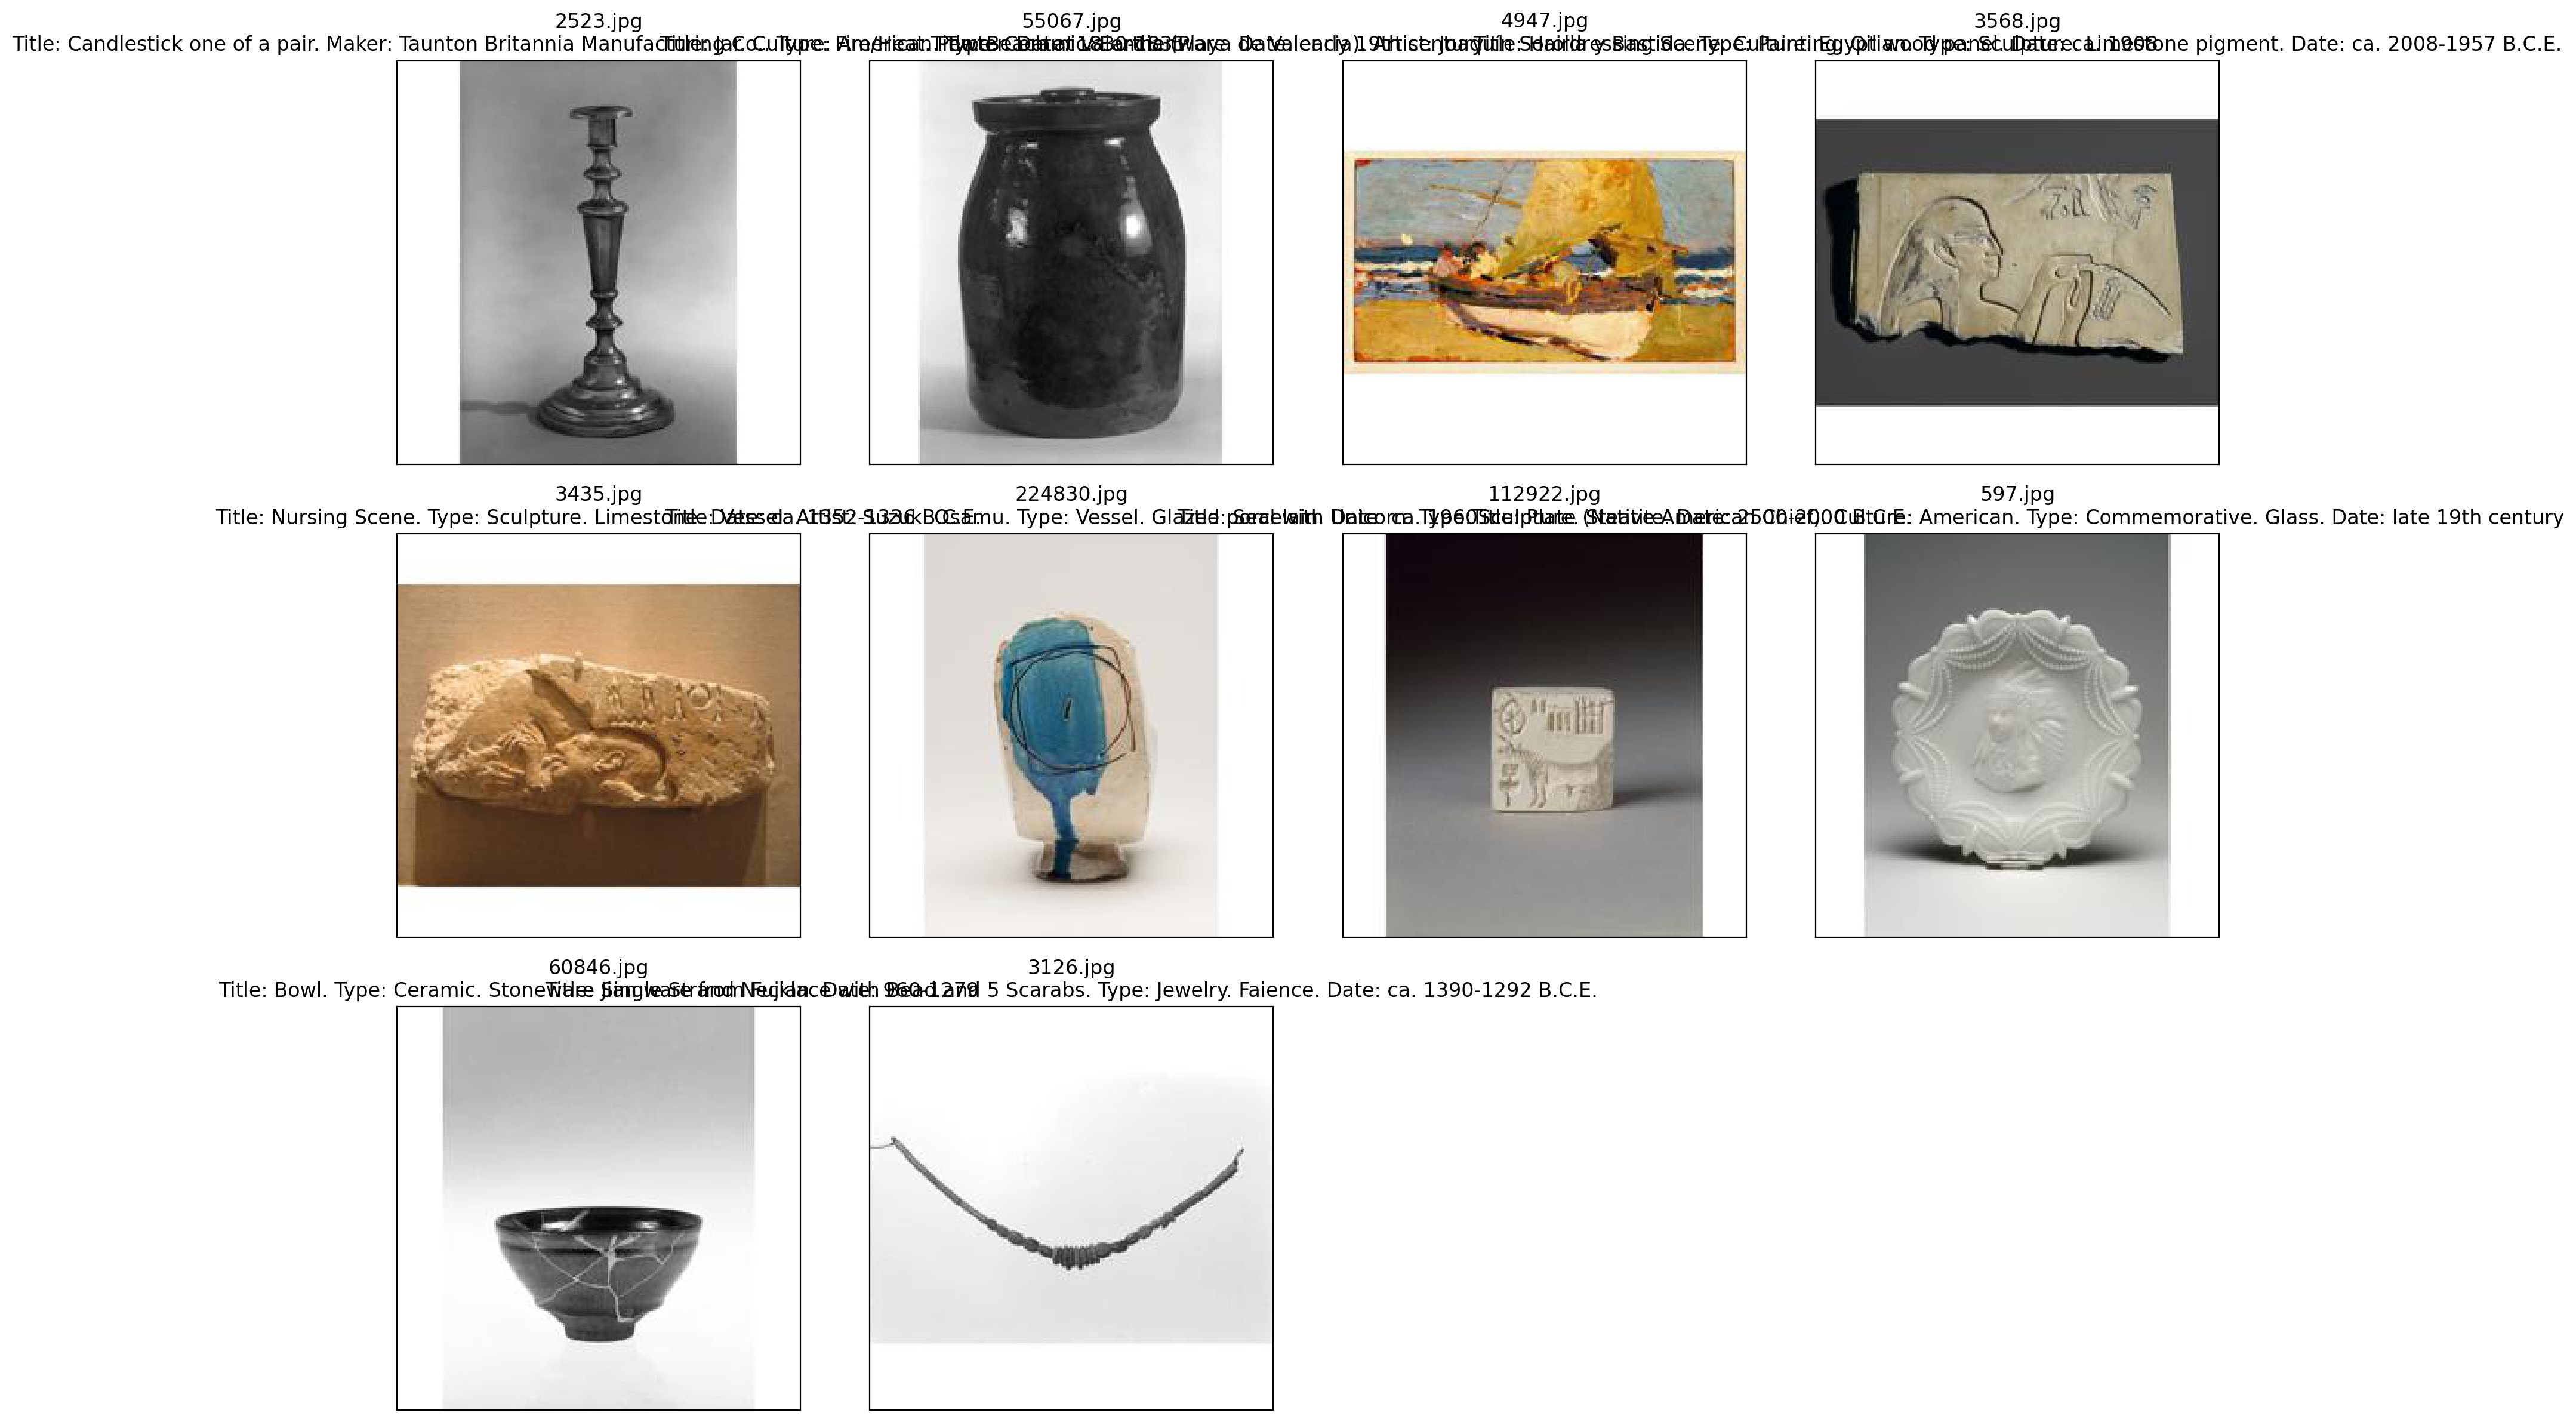

In [59]:
image_dir = "/content/images"
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 16))

for idx, filename in enumerate([filename for filename in os.listdir(image_dir) if filename.endswith(".jpg")]):
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(image_dir, filename)).convert("RGB")

    if idx < 16:
        plt.subplot(4, 4, len(images) + 1)
        plt.imshow(image)
        plt.title(f"{filename}\n{descriptions[name]}")
        plt.xticks([])
        plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

plt.savefig('/content/data_samples.png')

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [60]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts], context_length=77, truncate=True).cuda()

In [61]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [62]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

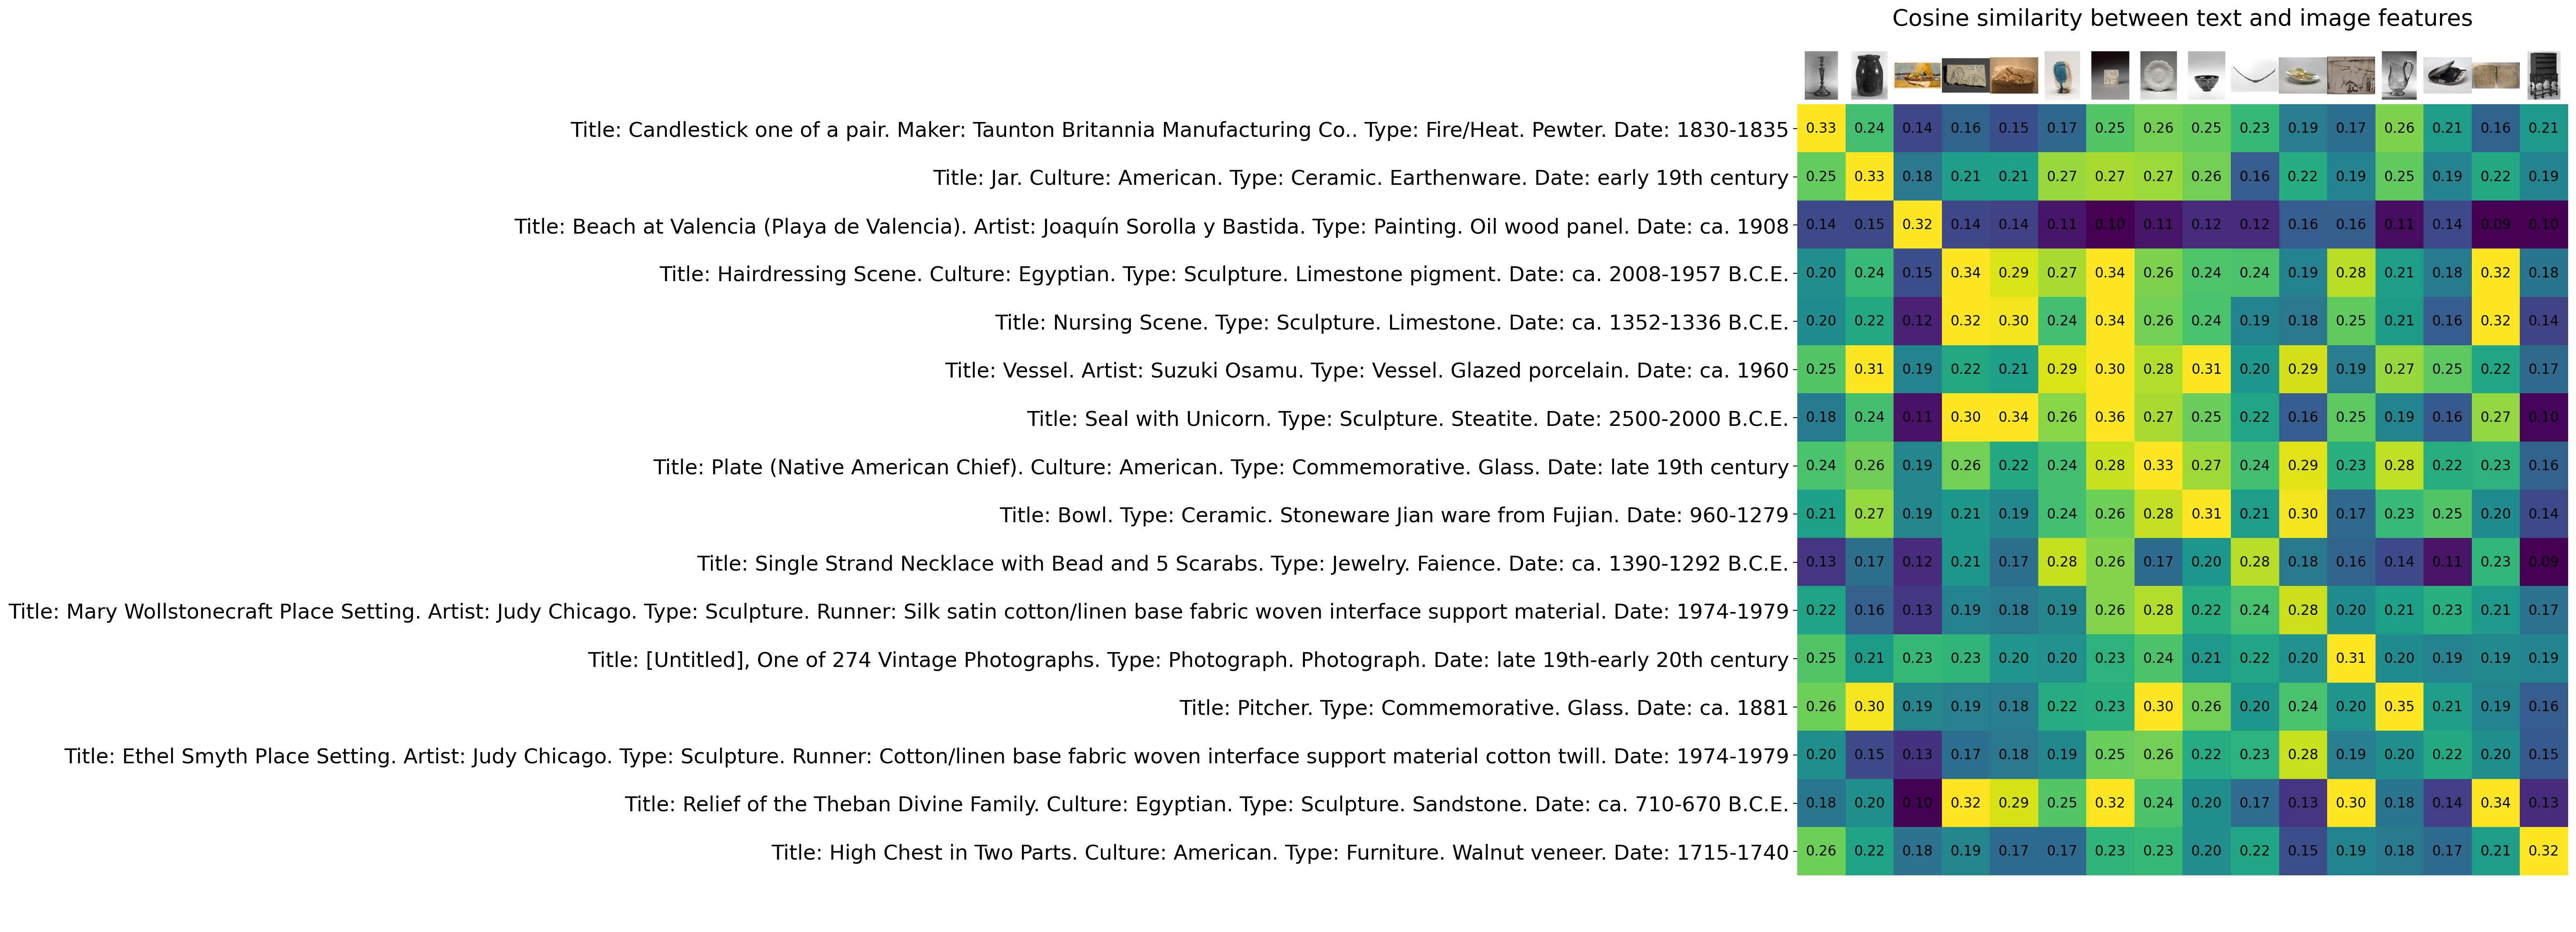

In [63]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

count = 16  # Set this to the number of images and descriptions you want to display.

plt.figure(figsize=(20, 14))
plt.subplots_adjust(left=0.25)
plt.imshow(similarity[:count, :count], vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts[:count], fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images[:count]):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(count):
    for y in range(count):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

plt.savefig('/content/cosine_similarity.png', bbox_inches='tight')

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [64]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [00:01<00:00, 105121185.71it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [65]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [66]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

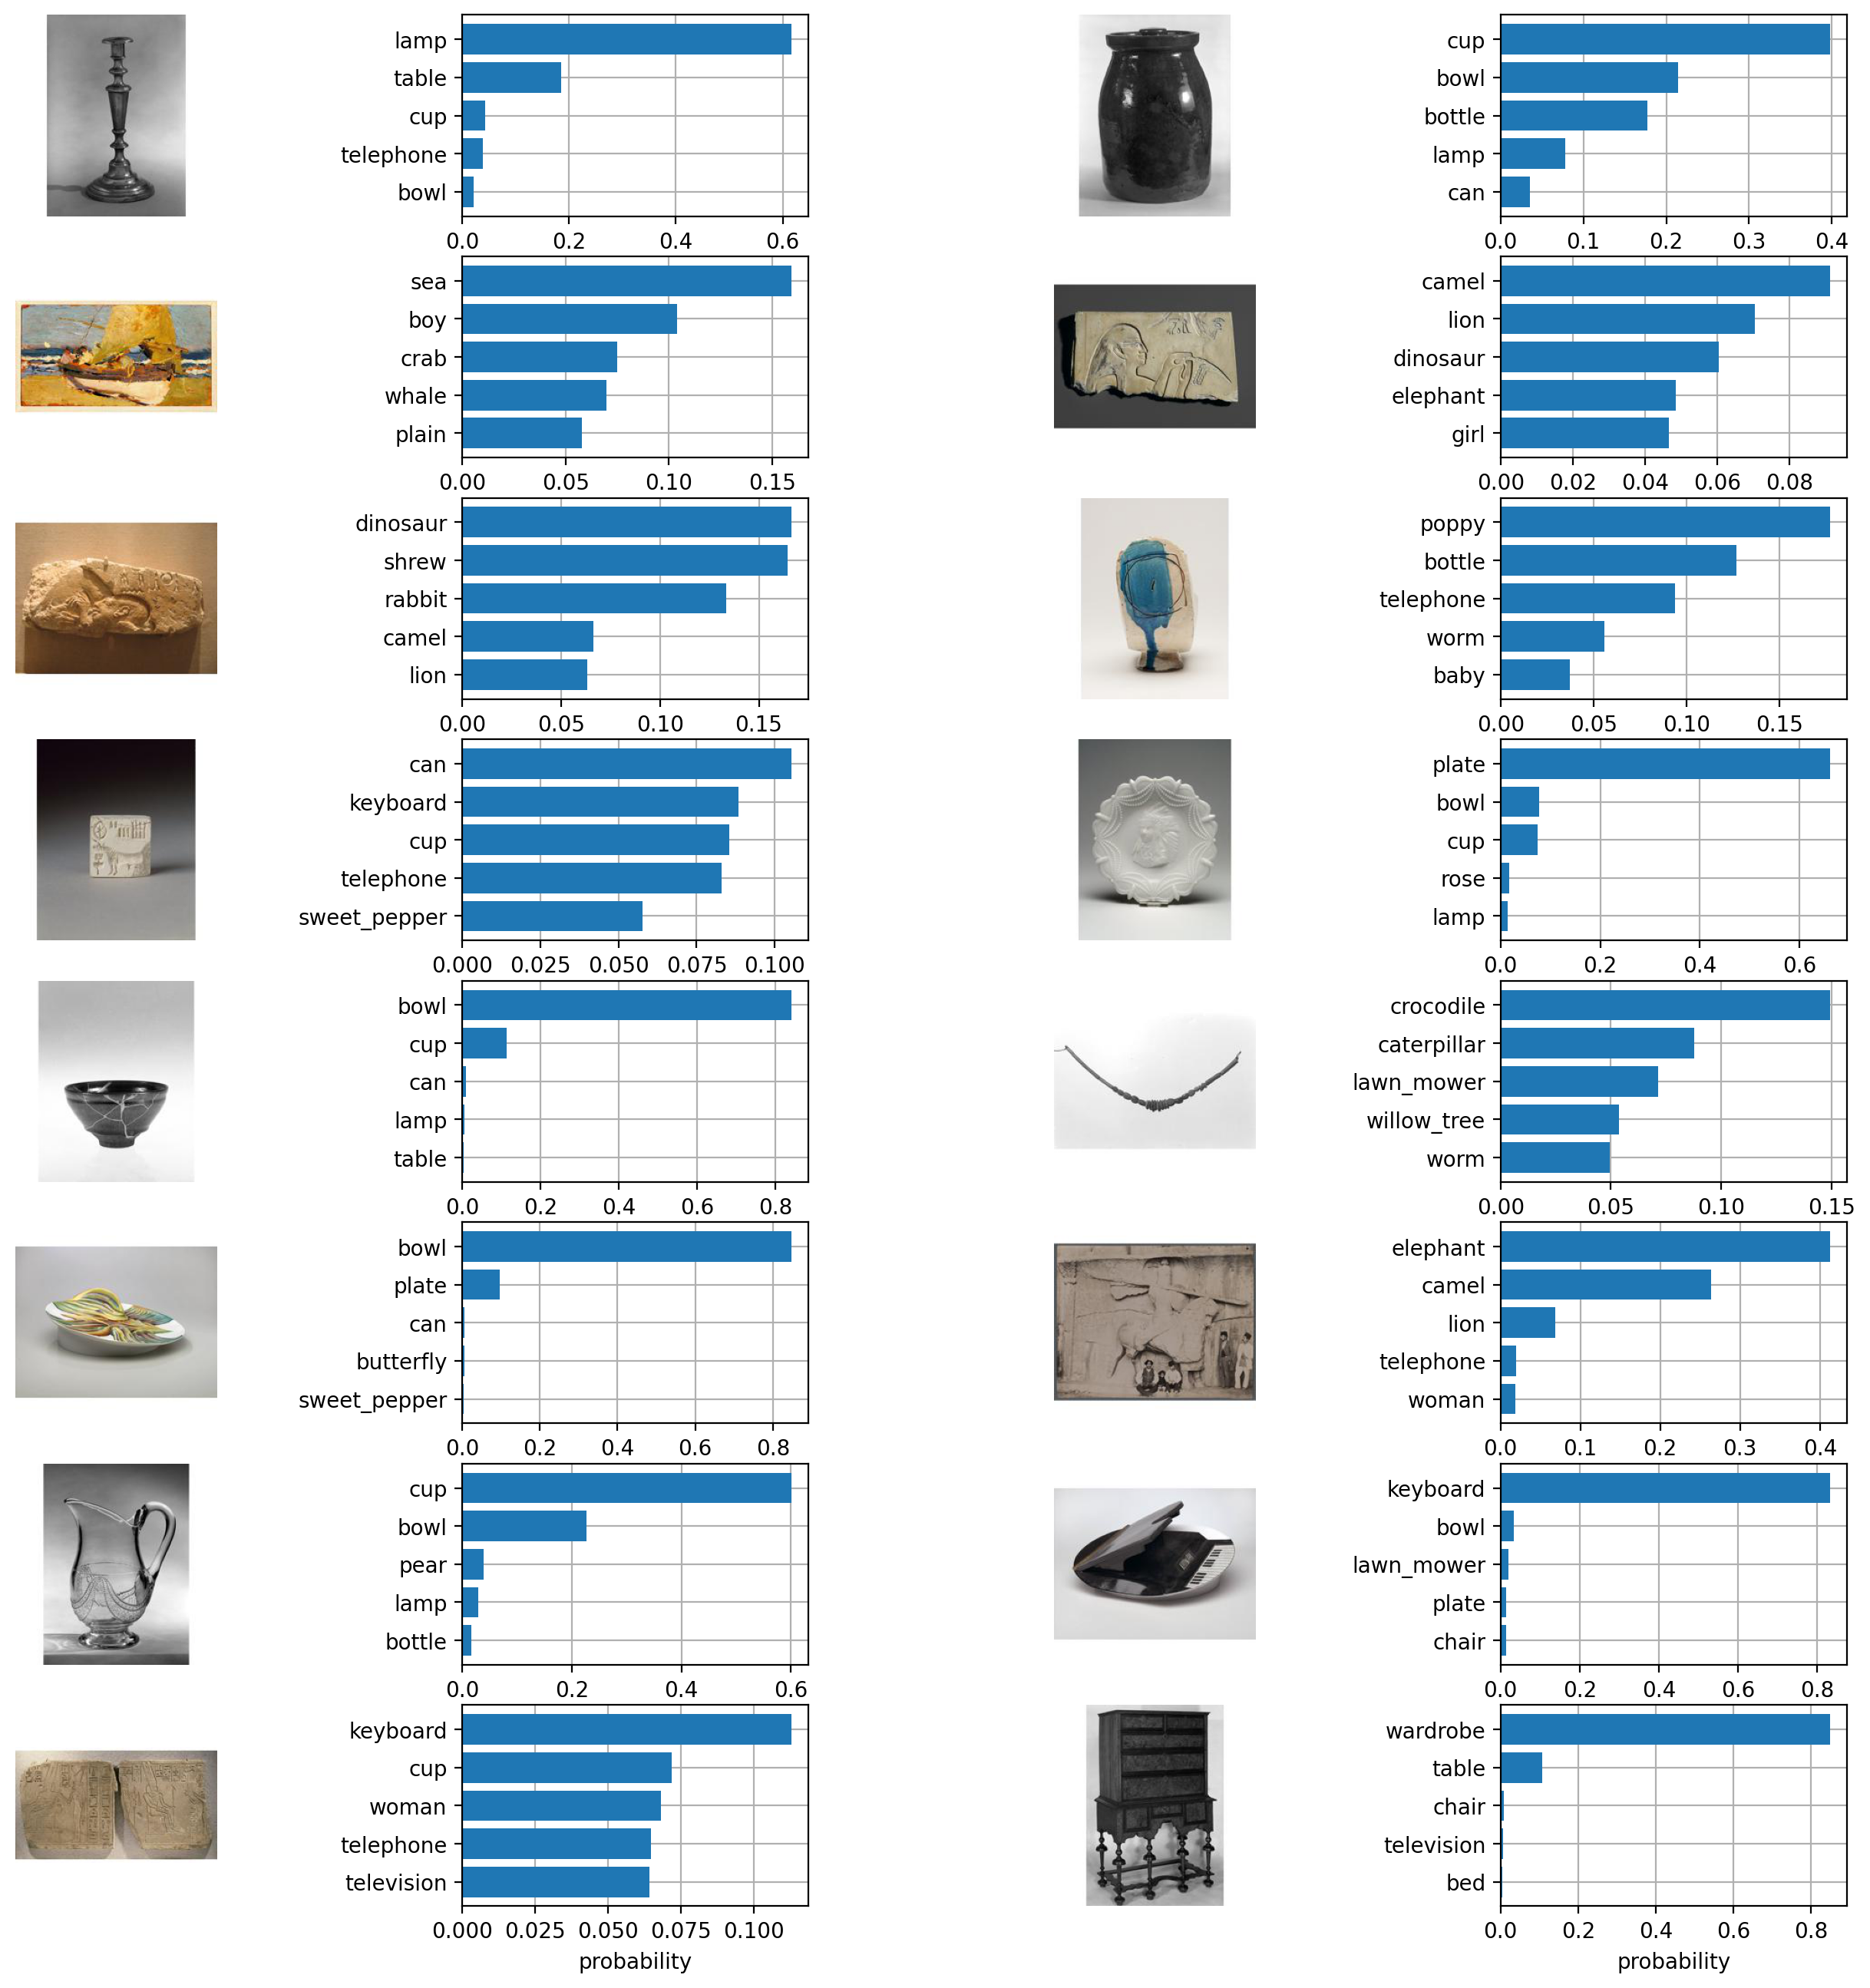

In [69]:
num_images = len(original_images)
max_images = 16  # Define the maximum number of images you want to plot
cols = 4  # The number of columns you want in your plot grid.

# Adjust the number of images to the maximum if necessary
if num_images > max_images:
    num_images = max_images

rows = num_images * 2 // cols  # The number of rows in the plot grid. Each image gets 2 subplots.
if num_images * 2 % cols:  # If there's a remainder, add an extra row.
    rows += 1

plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images[:max_images]):  # Loop over up to max_images images
    plt.subplot(rows, cols, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(rows, cols, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()



## Test Image Similarity

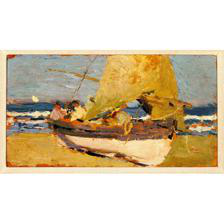

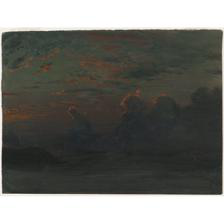

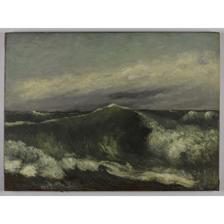

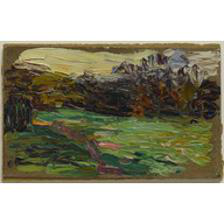

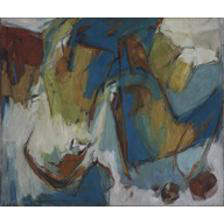

In [70]:
def get_image_features(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).cuda()
    with torch.no_grad():
        image_features = model.encode_image(image)
    return image_features / image_features.norm(dim=-1, keepdim=True)

test_image_features = get_image_features("/content/test_image.jpg")
test_image_features = test_image_features.float()
similarity_to_test = (image_features @ test_image_features.T).cpu().numpy()

k = 5  # For example, to find the top 5 most similar images

# argsort returns indices that would sort the array
# we use negative similarity to get indices of largest elements
most_similar_indices = np.argsort(-similarity_to_test, axis=0)[:k]

# Display the most similar images
for idx in most_similar_indices.flatten():
    display(original_images[idx])